In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import LSTM, GRU, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

from matplotlib.pyplot import figure #bigger figure


In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  #disable tensorflow warnings

In [3]:

def read_from_source():
    df = pd.read_csv('https://toyokeizai.net/sp/visual/tko/covid19/csv/pcr_positive_daily.csv')
    df = df.rename(columns={'日付': 'Date', 'PCR 検査陽性者数(単日)': 'Infected'}) #renaming from Japanese to English
    df['Date'] = pd.to_datetime(df['Date'])
    return df



def pred_covid(model_name, df, model_idx): #GRU or LSTM
    #model = load_model('../'+model_name +'_infected_only_GRU_LSTM_Oct16.h5') #best
    model = load_model('LSTM_GRU_Oct23_relu/' + model_name +'_infected_only_Oct23_'+str(model_idx)+'.h5')
    print(model_name,'loaded')

    #constant
    n_steps_in = 14
    n_steps_out = 4
    sc = MinMaxScaler(feature_range = (0, 1))
    
    x_input = df['Infected'][-n_steps_in:].values # last 14 day
    x_input = sc.fit_transform(x_input.reshape(len(x_input), 1))
    x_input = x_input.reshape((1, n_steps_in, 1))
    
    #y_pred = model.predict(x_input) # too much warnings
    y_pred = model(x_input)
    y_pred = sc.inverse_transform(y_pred) #revert scaling
    #print('Next 4 days prediction:', y_pred)
    
    start_date = str(df['Date'].iloc[-14])[:10]
    end_date = df['Date'].iloc[-15] + pd.Timedelta(18, unit='D')                  
    end_date = str(end_date)[:10]
    #print(start_date,'---', end_date)
    time_range = pd.date_range(start=start_date, end=end_date)
    
    pred_list = list(zip(time_range[-4:].strftime('%Y-%m-%d'), y_pred[0,:]))
    return pd.DataFrame (pred_list, columns = ['Date', 'Predict Infected'])

In [4]:
df = read_from_source()
#df = df.append({'Date':pd.to_datetime('2021-10-31'),'Infected':4284}, ignore_index = True) #anomaly
#df = df.append({'Date':pd.to_datetime('2021-11-01'),'Infected':5000}, ignore_index = True) #anomaly
#df = df.append({'Date':pd.to_datetime('2021-11-02'),'Infected':354}, ignore_index = True) #anomaly

df

,Date,Infected
0,2020-01-16,1.0
1,2020-01-17,0.0
2,2020-01-18,0.0
3,2020-01-19,0.0
4,2020-01-20,0.0
...,...,...
650,2021-10-27,310.0
651,2021-10-28,268.0
652,2021-10-29,291.0
653,2021-10-30,283.0


In [5]:
pred_covid('GRU', df,1)

GRU loaded


,Date,Predict Infected
0,2021-11-01,229.872584
1,2021-11-02,271.649920
2,2021-11-03,264.996540
3,2021-11-04,237.344102


In [6]:
def get_prediction(model, df): #model = 'GRU' or 'LSTM'
    pred_arr = []
    for model_idx in [1,2,3]:
        #print(model,model_idx,pred_covid(model, df,model_idx))
        pred_arr.append(np.array(pred_covid(model, df,model_idx)['Predict Infected'].values))
    return np.array(pred_arr)

In [7]:
def get_PI(pred_arr):
    intervals = []
    means = []
    uppers = []
    lowers = []
    for idx in [0,1,2,3]:
        cov_std = pred_arr[:,idx].std()
        cov_interval = cov_std*1.96
        cov_mean = pred_arr[:,idx].mean()
        cov_lower = cov_mean - cov_interval
        if (cov_lower<0):
            cov_lower = 0
        cov_upper = cov_mean + cov_interval
        print(pred_arr[:,idx], 'Interval: ',cov_interval , 'Lower: ',cov_lower, 'Mean: ',cov_mean, 'Upper: ',cov_upper)
        
        intervals.append(int(cov_interval))
        means.append(int(cov_mean))
        uppers.append(int(cov_upper))
        lowers.append(int(cov_lower))
    
    return intervals, means, uppers, lowers

### Looping through 2 models to get y_pred_mean for XGB

LSTM loaded
LSTM loaded
LSTM loaded
[250.18172693 243.69551611 193.16988659] Interval:  49.95014317997 Lower:  179.06556669704418 Mean:  229.01570987701416 Upper:  278.96585305698414
[213.03223801 263.07697248 180.11280727] Interval:  66.85492379962037 Lower:  151.88574878872802 Mean:  218.7406725883484 Upper:  285.5955963879687
[211.28387403 282.30874729 183.35404229] Interval:  81.6448208879383 Lower:  144.00406698475763 Mean:  225.64888787269592 Upper:  307.2937087606342
[245.87107372 286.51765537 198.43717289] Interval:  70.54878035376791 Lower:  173.05985364128824 Mean:  243.60863399505615 Upper:  314.1574143488241
GRU loaded
start date:  2021-10-18
end date:  2021-11-04


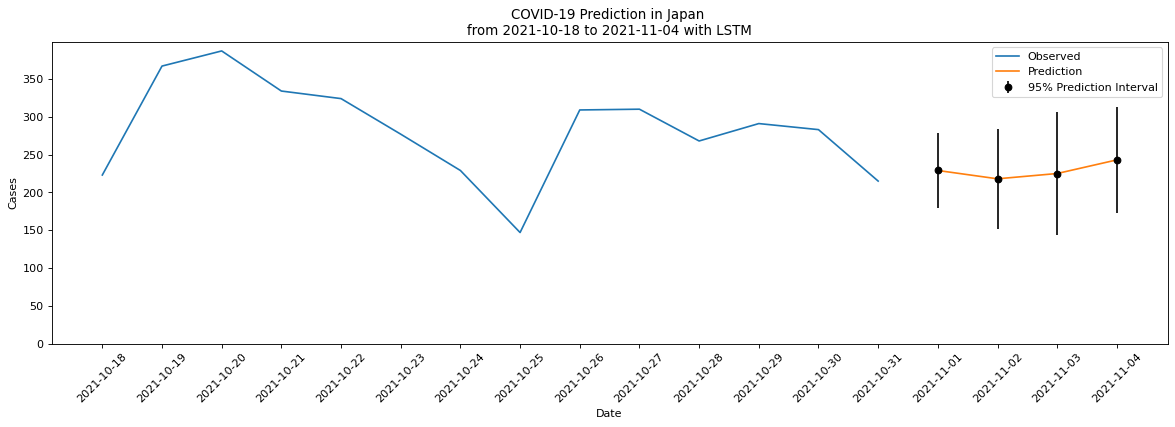

GRU loaded
GRU loaded
GRU loaded
[229.87258387 215.75211239 226.82324123] Interval:  11.89095562214348 Lower:  212.25835687404182 Mean:  224.1493124961853 Upper:  236.04026811832878
[271.64992046 252.27807713 252.03067017] Interval:  18.01405407250994 Lower:  240.63883517919905 Mean:  258.652889251709 Upper:  276.66694332421895
[264.99654007 304.39710331 270.39706421] Interval:  34.18358816353648 Lower:  245.74664769919545 Mean:  279.93023586273193 Upper:  314.1138240262684
[237.34410238 260.36731911 273.61711693] Interval:  29.373544320249366 Lower:  227.73596848568934 Mean:  257.1095128059387 Upper:  286.4830571261881
GRU loaded
start date:  2021-10-18
end date:  2021-11-04


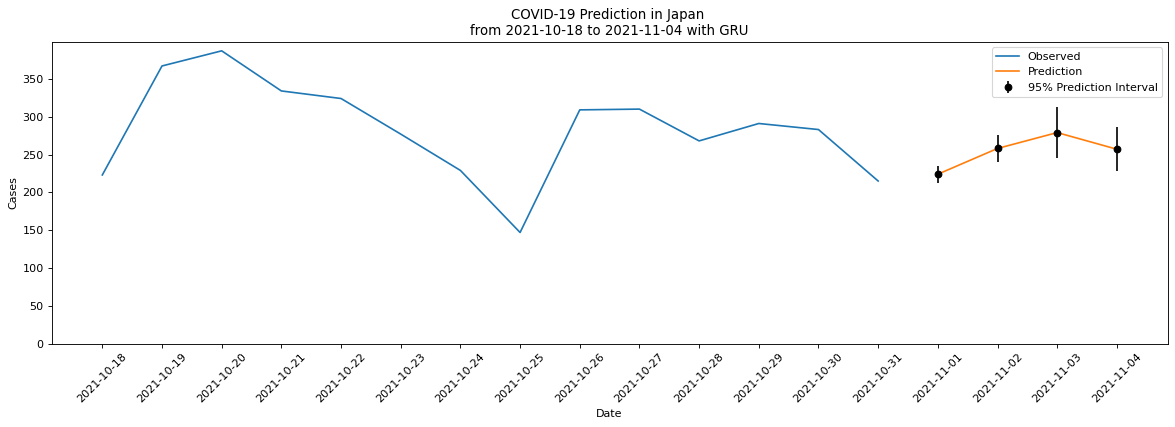

Wall time: 11.7 s


In [8]:
%%time
for model_type in ['LSTM','GRU']:
    pred_arr = get_prediction(model_type,df)
    cov_intervals, cov_means, cov_uppers, cov_lowers = get_PI(pred_arr)
    y_pred = cov_means
    
    start_date = str(df[-14:]['Date'].iloc[0])[:10]
    end_date = pred_covid('GRU', df,3)['Date'][3]
    time_range = pd.date_range(start = start_date, end= end_date)
    print('start date: ',start_date)
    print('end date: ',end_date)
    
    figure(figsize=(18, 5), dpi=80)
    plt.plot(time_range[:-4], df['Infected'][-14:], label='Observed')
    plt.plot(time_range[-4:], y_pred, label='Prediction')

    plt.errorbar(time_range[-4], y_pred[0], yerr=cov_intervals[0], color='black', fmt='o', label='95% Prediction Interval')
    plt.errorbar(time_range[-3], y_pred[1], yerr=cov_intervals[1], color='black', fmt='o')
    plt.errorbar(time_range[-2], y_pred[2], yerr=cov_intervals[2], color='black', fmt='o')
    plt.errorbar(time_range[-1], y_pred[3], yerr=cov_intervals[3], color='black', fmt='o')

    plt.xlabel('Date')
    plt.ylabel('Cases')
    plt.xticks(time_range,rotation=45)
    plt.title('COVID-19 Prediction in Japan \nfrom {0} to {1} with {2}'.format(start_date, end_date, model_type))
    plt.legend()
    plt.ylim(0, None) # Or similarly "plt.ylim(0)" #important

    plt.show()

### Sample code, do not delete